# Sagemaker : model traning and deployment 

In [1]:
# importing the necossery liberay 
import sagemaker
from sagemaker.tensorflow import TensorFlow
import os

import numpy as np
import pandas as pd
from sklearn.utils import class_weight

from Data import Data # Data processing libery 

In [2]:
# Downloading data from S3

import boto3
 
from sagemaker import get_execution_role
role = get_execution_role()
 
my_bucket = 'facesong'
orig_file = 'Raw_data/icml_face_data.csv.zip'
dest_file = 'icml_face_data.csv.zip'
 
s3 = boto3.resource('s3')
s3.Bucket(my_bucket).download_file(orig_file, dest_file)

In [3]:
df = pd.read_csv("icml_face_data.csv.zip")

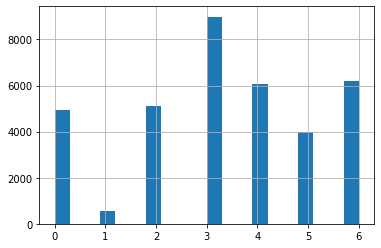

In [4]:
df['emotion'].hist(bins = 20)


#### as this is a very unbalanced data set we can not feed it to our model as it is 
#### there are many approches to this problem 
#### we will use the class vise loss to make the model unbise 
#### ( one more approach would be to remove the 1 and 3 classes but that would be unnessery data loss )

### class weights is implimentated in the train.py  

In [8]:
# prepross the data

data = Data()
Train_X , Train_y , Test_X ,Test_y = data.Get_data()

In [9]:
# save the preprossesd data in the local dir 

data_dir = os.path.join(os.getcwd(), 'data')
os.makedirs(data_dir, exist_ok=True)

train_dir = os.path.join(os.getcwd(), 'data/train')
os.makedirs(train_dir, exist_ok=True)

test_dir = os.path.join(os.getcwd(), 'data/test')
os.makedirs(test_dir, exist_ok=True)


np.save(os.path.join(train_dir, 'Train_X.npy'), Train_X)
np.save(os.path.join(train_dir, 'Train_y.npy'),  Train_y.astype('float32'))
np.save(os.path.join(test_dir, 'Test_X.npy'), Test_X)
np.save(os.path.join(test_dir, 'Test_y.npy'), Test_y.astype('float32'))

In [10]:

# Upload the preprossed data to s3 

s3_prefix = 'facesong' 
Sagemaker_session = sagemaker.Session()


traindata_s3_prefix = '{}/data/train'.format(s3_prefix)
testdata_s3_prefix = '{}/data/test'.format(s3_prefix)

train_s3 = Sagemaker_session.upload_data(path='./data/train/', key_prefix=traindata_s3_prefix)
test_s3 = Sagemaker_session.upload_data(path='./data/test/', key_prefix=testdata_s3_prefix)

inputs = {'train':train_s3, 'test': test_s3} # locations of the data 

In [11]:
print(inputs) # input params to the model

{'train': 's3://sagemaker-us-east-1-478270364551/facesong/data/train', 'test': 's3://sagemaker-us-east-1-478270364551/facesong/data/test'}


In [26]:
!pygmentize 'train.py'

import tensorflow as tf
import argparse
import os
import numpy as np
import json
from tensorflow.keras import Model
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout ,BatchNormalization,Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from sklearn.utils import class_weight


def get_model():
    
    n_classes = 7
    #layer 1
    model = Sequential()
    model.add(Conv2D(64,(3,3),padding='same',input_shape=(48,48,1)) )
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    #layer 2
    model.add(Conv2D(128,(5,5),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2

In [27]:
# create a new SageMaker TensorFlow job using sagemaker.tensorflow class

from sagemaker.tensorflow import TensorFlow


estimator = TensorFlow(entry_point='train.py',
                             role=role,
                             train_instance_count=2,
                             train_instance_type='ml.m4.xlarge',
                             framework_version='2.1.0',
                             py_version='py3',
                             #hyperparameters={'class_weights' : class_weights},
                       
                             distributions={'parameter_server': {'enabled': True}})

distributions has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [ ]:
#train the model 
# the estaminator will download the container image when runnig for the first time 
#and it may take a long time to run this cell 
estimator.fit(inputs)

2021-01-04 11:18:32 Starting - Starting the training job...
2021-01-04 11:18:55 Starting - Launching requested ML instancesProfilerReport-1609759111: InProgress
......
2021-01-04 11:20:02 Starting - Preparing the instances for training............
2021-01-04 11:21:58 Downloading - Downloading input data
2021-01-04 11:21:58 Training - Downloading the training image...
2021-01-04 11:22:27 Training - Training image download completed. Training in progress..2021-01-04 11:22:30,749 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2021-01-04 11:22:30,756 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-01-04 11:22:31,093 sagemaker_tensorflow_container.training INFO     Running distributed training job with parameter servers
2021-01-04 11:22:31,093 sagemaker_tensorflow_container.training INFO     Launching parameter server process
2021-01-04 11:22:31,093 sagemaker_tensorflow_container.training INFO     Running distribute

In [ ]:

# deploying th eendpoint 

predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


---

In [1]:
# display endppoint 
predictor.endpoint

Testing the model

In [ ]:
predictions = predictor.predict(y_test)['predictions']

In [ ]:

# creating the heat map @!!

%matplotlib inline
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = confusion_matrix(y_pred=predictions,y_true=actual)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sn.set(rc={'figure.figsize':(11.7,8.27)})
sn.set(font_scale=1.4)#for label size
sn.heatmap(cm, annot=True,annot_kws={"size": 10})# font size